In [3]:
import jax
from tinygp import kernels
from tinygp import GaussianProcess

import numpy as np
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

In [4]:
kernel = 0.5 * kernels.ExpSquared(scale=1.5)
DESI_2024_sigmaz_corr_pzbin1 = np.load('data/Fig1_Fig8_dr10_allfoot_perbin_sigmaz0.0500_dr6_corr_pzbin1.npz')

X=DESI_2024_sigmaz_corr_pzbin1['theta_arcmins']
y=DESI_2024_sigmaz_corr_pzbin1['prof']

gp = GaussianProcess(kernel, X, diag=1e-4)


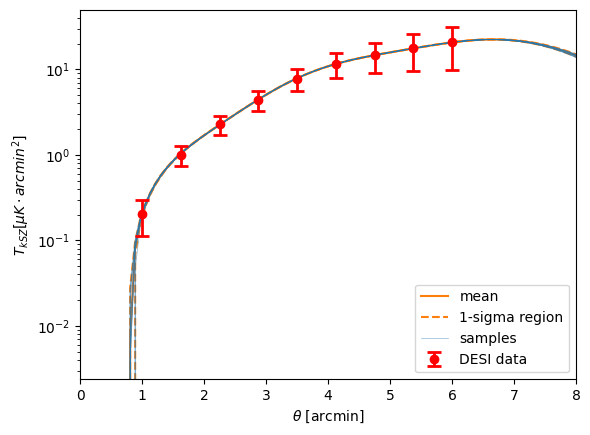

In [7]:
X_test = np.linspace(0, 8, 100)
_, cond_gp = gp.condition(y, X_test)

# The GP object keeps track of its mean and variance, which we can use for
# plotting confidence intervals
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)
plt.plot(X_test, mu, "C1", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)

plt.errorbar(DESI_2024_sigmaz_corr_pzbin1['theta_arcmins'], DESI_2024_sigmaz_corr_pzbin1['prof'], yerr=np.sqrt(DESI_2024_sigmaz_corr_pzbin1['cov'].diagonal()), color='r',
             fmt='o',capsize=5, capthick=2, linewidth=2, markersize=6, label="DESI data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())

plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$T_{kSZ} [\mu K \cdot arcmin^2]$')
plt.yscale('log')
plt.show()

# TRAINING...!

## jaxopt.ScipyMinimize training NN+GP -- loss landscape not smooth, memory-intensive

In [ ]:
import importlib
import GP_dataloader
importlib.reload(GP_dataloader) 
from GP_dataloader import *
import train_GP
importlib.reload(train_GP) 
from train_GP import *

sim_indices_train = np.load('data/sparse_sampling_train_indices_random.npy')  # Training simulations
gp_models, best_params_list, model_info_list = train_NN_gp(sim_indices_train, filterType='CAP', ptype='gas', save=True)

JAX devices: [CpuDevice(id=0)]
Using device: TFRT_CPU_0
Getting gas profiles with CAP filter for 204 simulations...
Finished getting profiles in 13872 halos.
Profiles shape: (13872, 21), Mass shape: (13872,), Params shape: (13872, 35), PkRatio shape: (13872, 255)


Training GP for each r_bin:   0%|          | 0/21 [00:00<?, ?it/s]

Start Adamw training for r_bin 0: Initial loss = 481190.4375


Training GP for each r_bin:   0%|          | 0/21 [00:28<?, ?it/s, Step=0, Loss=481190.468750, Best=481190.468750]

In [8]:
sim_indices_test = np.load('data/sparse_sampling_train_indices_random.npy')  # Testing simulations sparse_sampling_test_indices_random
X_test, y_test, r_bins, k_bins = prepare_GP_data(sim_indices_test, 'CAP', 'gas')
X_train, y_train, r_bins, k_bins = prepare_GP_data(sim_indices_train, 'CAP', 'gas')

pred_means = []
pred_vars = []

model = build_NN_gp()

for i in range(len(gp_models)):
    cond_gp =  model.apply(best_params_list[i], X_train, y_train[:,i])[1]
    #cond_gp = gp_models[i](X_train[i], X_test)
    pred_means.append(cond_gp.mean)
    pred_vars.append(cond_gp.variance)
pred_means = jnp.array(pred_means)
pred_vars = jnp.array(pred_vars)
print(pred_means.mean())

Getting gas profiles with CAP filter for 204 simulations...
Finished getting profiles in 13872 halos.
Profiles shape: (13872, 21), Mass shape: (13872,), Params shape: (13872, 35), PkRatio shape: (13872, 255)
Getting gas profiles with CAP filter for 20 simulations...
Finished getting profiles in 1360 halos.
Profiles shape: (1360, 21), Mass shape: (1360,), Params shape: (1360, 35), PkRatio shape: (1360, 255)
7.1742496


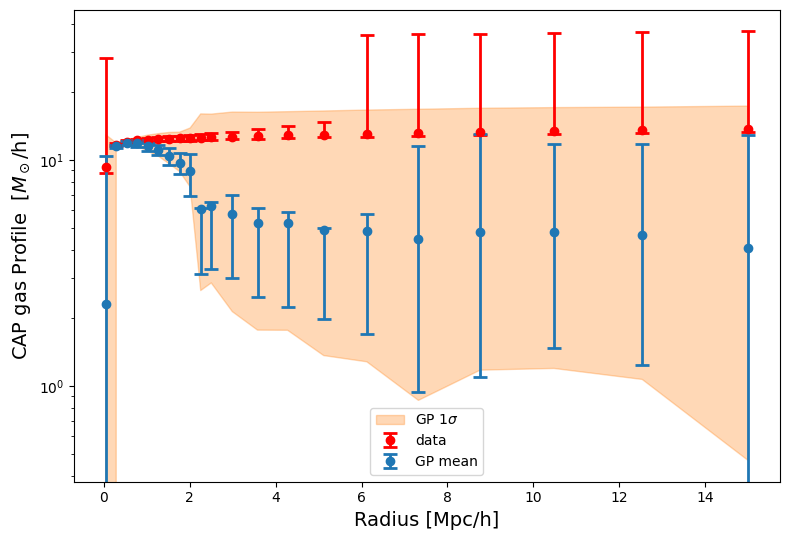

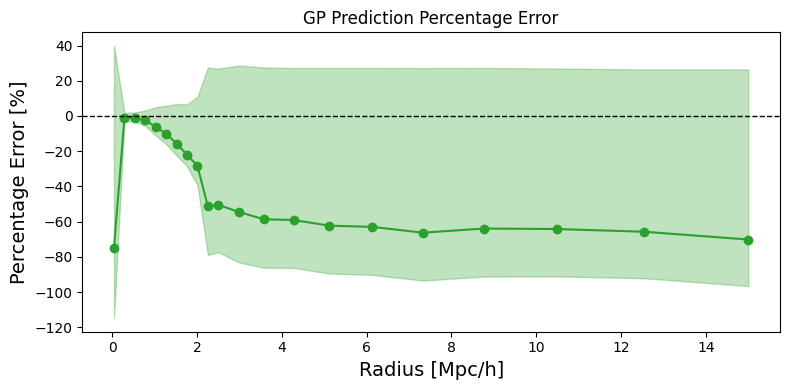

<Figure size 640x480 with 0 Axes>

In [16]:
# Plot example prediction with uncertainty
fig, ax1 = plt.subplots(figsize=(8,5.5))
#y_test = 10**y_test - 1e-10
upper = np.quantile(y_test, 0.25, axis=0)
lower = np.quantile(y_test, 0.75, axis=0)
median = np.median(y_test, axis=0)
yerr_lower = np.abs(median - lower)
yerr_upper =  np.abs(upper - median)
yerr = [yerr_lower, yerr_upper]
ax1.errorbar(r_bins, median, yerr=yerr, fmt='o', capsize=5, capthick=2, linewidth=2, markersize=6, color='r',label='data')

#pred_means = 10**pred_means - 1e-10
upper_pred = np.quantile(pred_means, 0.25, axis=1)
lower_pred = np.quantile(pred_means, 0.75, axis=1)
median_pred = np.mean(pred_means, axis=1)
yerr_lower = np.abs(median_pred - lower_pred)
yerr_upper =  np.abs(upper_pred - median_pred)
yerr = [yerr_lower, yerr_upper]
ax1.errorbar(r_bins, median_pred, yerr=yerr, 
            fmt='o', capsize=5, capthick=2, linewidth=2, markersize=6, label='GP mean')
ax1.fill_between(r_bins, median_pred - np.mean(np.sqrt(pred_vars), axis=1), median + np.mean(np.sqrt(pred_vars), axis=1), color='C1', alpha=0.3, label='GP 1$\sigma$')
ax1.set_yscale('log')
ax1.legend()
ax1.set_xlabel('Radius [Mpc/h]', fontsize=14)
ax1.set_ylabel(r'CAP gas Profile  [$M_\odot$/h]', fontsize=14   
               )
plt.tight_layout()
plt.show()

# Compute percentage error at each bin
percent_error = lambda x: 100 * (x.squeeze() - median) / median
fig2, ax2 = plt.subplots(figsize=(8, 4))
ax2.plot(r_bins, percent_error(median_pred), marker='o', linestyle='-', color='C2')
ax2.fill_between(r_bins, percent_error(median_pred - np.mean(np.sqrt(pred_vars), axis=1)), percent_error(median + np.mean(np.sqrt(pred_vars), axis=1)), color='C2', alpha=0.3, label='GP 1$\sigma$')
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.set_xlabel('Radius [Mpc/h]', fontsize=14)
ax2.set_ylabel('Percentage Error [%]', fontsize=14)
ax2.set_title('GP Prediction Percentage Error')
plt.tight_layout()
plt.show()
plt.savefig('trained_gp_models/NN_gp_090418/test_plot.png')

In [11]:
pred_means.shape

(21, 1360)

In [36]:
median

array([      nan, 11.878035,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan], dtype=float32)

In [37]:
y_test

Array([[ 9.61538  , 12.512642 , 12.991692 , ..., 14.041281 , 14.409862 ,
        14.665671 ],
       [10.208596 , 12.461899 , 12.800271 , ..., 14.065907 , 14.237939 ,
        14.433366 ],
       [10.142992 , 12.491848 , 12.879576 , ...,        nan, 13.666782 ,
        14.266562 ],
       ...,
       [ 8.403083 , 11.677702 , 12.114396 , ...,        nan,        nan,
               nan],
       [       nan, 11.641543 , 12.009924 , ..., 13.66927  , 13.423564 ,
        13.8677   ],
       [       nan, 11.714598 , 11.981025 , ..., 13.3996105, 13.690705 ,
        14.167968 ]], dtype=float32)